In [103]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import nltk
from nltk.corpus import stopwords
from pymongo import MongoClient
from time import time
from collections import Counter
import pandas as pd
import numpy as np
import os


%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# default plot stying changes
import seaborn as sns
sns.set_style("white")
sns.set_context("poster", font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.set_palette("Set2")
colors = sns.color_palette('Set2',12)

# Credentials

In [2]:
pw_file = 'pw.txt'
if os.path.exists(pw_file): 
    with open(pw_file, 'r') as f:
        email, indeed_pw = f.readline().strip().split(', ')
        username, pia_pw = f.readline().strip().split(', ')
        pub_ip, mongo_usr, mongo_usr_pw = f.readline().strip().split(', ')

# Connect to DB

In [3]:
# connect to ec2 mongo client
client = MongoClient('{0}:27017'.format(pub_ip))


In [4]:
# get reference to  resume_db
db = client.resume_db

In [5]:
# authenticate user for database
db.authenticate(mongo_usr, mongo_usr_pw)

True

# Pull MongoDB into Dataframe

In [6]:
def read_mongo(db, collection, query={}, no_id=True):
    '''
    db: mongodb already connected and authenticated
    collection: desired collection in db
    query: query filter
    no_id: include mongos _id (False) or not (True)
    return => pandas dataframe
    '''
    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df

In [7]:
t_start = time()

# load database data into dataframe
df = read_mongo(db, 'originals')

print('Time to load data: {0}s'.format(time() - t_start))

Time to load data: 15.223574876785278s


In [8]:
df.head()

link_id                                        resume_text  \
0  /r/2b5b06cff39ce808?  Petros Gazazyan North Hollywood, CA Werkervari...   
1  /r/8fe4de80947b60f2?  Travis London Java Software Engineer Tucson, A...   
2  /r/1c009e8f7e2f5309?  Stephen A. Kraft Mechanical Engineer Seattle, ...   
3  /r/f18875e484d5b766?  Abdy Galeano Duarte, CA Utilize my skills and ...   
4  /r/818d4e5de7455e18?  Thithi McWilliams New Product Development Engi...   

  search_term  
0    engineer  
1    engineer  
2    engineer  
3    engineer  
4    engineer

In [9]:
print(list(df['search_term'].unique()))

['engineer', 'analytics', 'data_analysis', 'data', 'big_data', 'scientist']


# Remove StopWords

In [10]:
# cache stopwords first to reduce compute time
cachedStopWords = stopwords.words("english")
cachedStopWords.append(',')

# convert all text to lower case and separate into list
df['resume_stopped'] = df['resume_text'].str.lower().str.split()

# remove stopwords
df['resume_stopped'] = df['resume_stopped'].apply(lambda x: ' '.join([item for item in x if item not in cachedStopWords]))

In [11]:
df.head()

link_id                                        resume_text  \
0  /r/2b5b06cff39ce808?  Petros Gazazyan North Hollywood, CA Werkervari...   
1  /r/8fe4de80947b60f2?  Travis London Java Software Engineer Tucson, A...   
2  /r/1c009e8f7e2f5309?  Stephen A. Kraft Mechanical Engineer Seattle, ...   
3  /r/f18875e484d5b766?  Abdy Galeano Duarte, CA Utilize my skills and ...   
4  /r/818d4e5de7455e18?  Thithi McWilliams New Product Development Engi...   

  search_term                                     resume_stopped  
0    engineer  petros gazazyan north hollywood, ca werkervari...  
1    engineer  travis london java software engineer tucson, a...  
2    engineer  stephen a. kraft mechanical engineer seattle, ...  
3    engineer  abdy galeano duarte, ca utilize skills experie...  
4    engineer  thithi mcwilliams new product development engi...

# Word Frequency

In [24]:
# get wordcounts
wordcount = Counter(' '.join(df['resume_stopped']).split(' '))

# limit wordcounts for visualization
wordcount = wordcount.most_common(25)

In [25]:
labels = [lbl for lbl, ct in wordcount]
count = [ct for lbl, ct in wordcount]

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


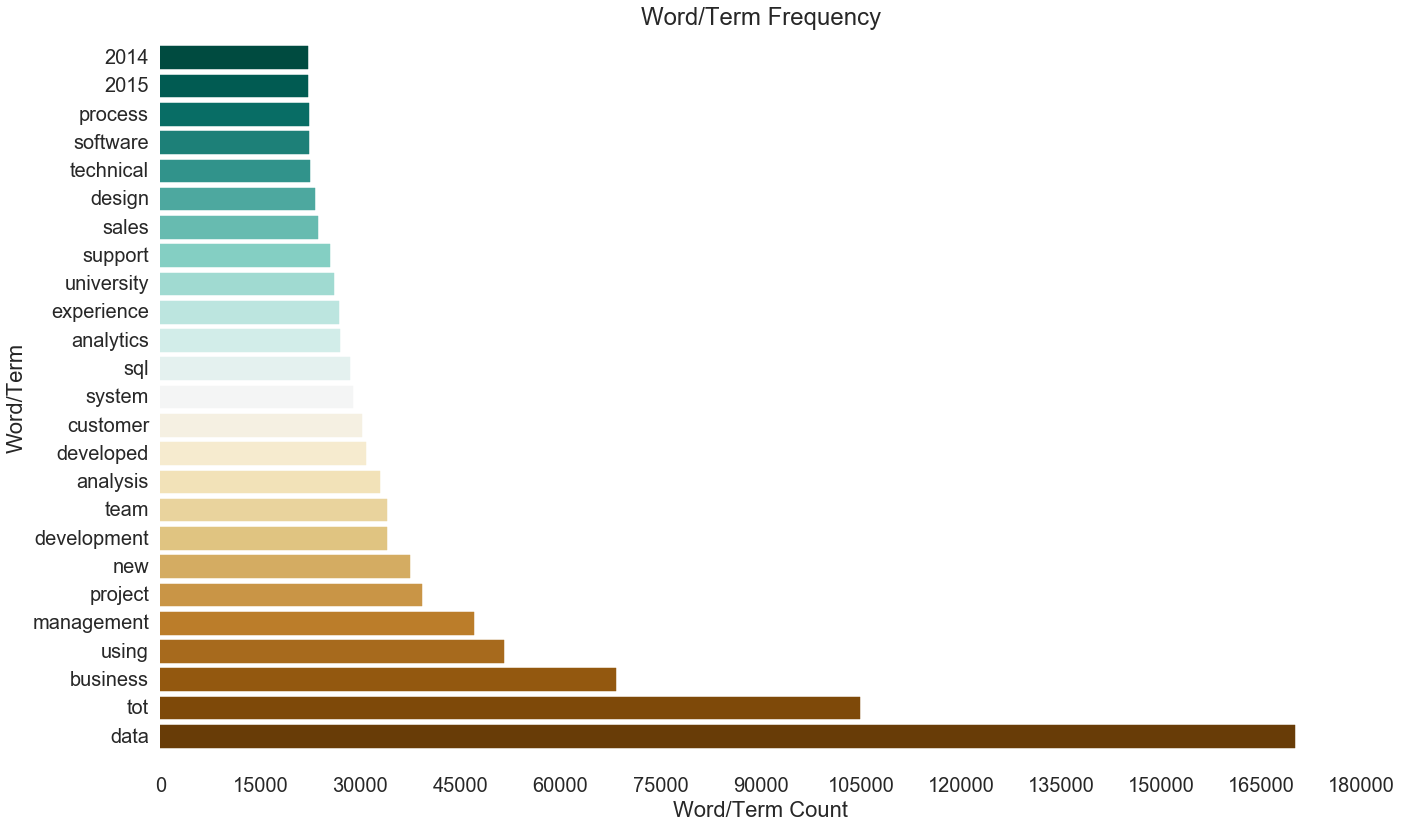

In [87]:
# make figure
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111)

# color
colors = sns.color_palette("BrBG", len(labels))

# plots
y_pos = np.arange(len(labels))
ax.barh(y_pos, count, align='center', color=colors, edgecolor=colors)

#plt.xlim(0,170000)
plt.ylim(-1,25)

# labels/titles
plt.legend(loc="best")
plt.title('Word/Term Frequency')
plt.xlabel('Word/Term Count')
plt.yticks(y_pos, labels)
plt.ylabel('Word/Term')
plt.xticks(np.linspace(0,180000, 13))

# remove border
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["bottom"].set_visible(False) 
ax.spines["left"].set_visible(False)

# show grid
#ax.xaxis.grid(True, alpha=0.2, linestyle='--') 
#ax.yaxis.grid(True, alpha=0.2, linestyle='--') 

# plot that biddy
plt.tight_layout()
_ = plt.show()

# Stemming

In [110]:
fd = nltk.FreqDist(w.lower() for w in df['resume_stopped'])
#fd.plot(10)
fd

FreqDist({'forrest wright data manager global entrepreneurship monitor philadelphia, pa werkervaring data manager global entrepreneurship monitor mei 2015 tot heden develop surveys entrepreneurial activity 70 countries using qualtrics software utilize spss software run data quality checks code survey responses write contribute special topic reports implementation specialist; data specialist thomson reuters corporation philadelphia, pa augustus 2012 tot april 2015 designed implemented data management systems three university customers created delivered custom research datasets 144 university government customers educated customers data management products teleconference calls, webex presentations, written documentation collections manager independence seaport museum philadelphia, pa januari 2012 tot augustus 2012 managed display preservation museum objects supervised four workers object cataloging website development projects records manager history associates, inc philadelphia, pa janu

# N-Grams Count Vectorizer

In [88]:
n_samples = 2000
n_features = 1000
n_topics = 10
n_top_words = 20

In [90]:
t_start = time()

# convert resume texts to a sparse matrix of token counts
ct_vect = CountVectorizer(ngram_range=(1, 3), max_df=0.90, min_df=2, max_features=n_features, stop_words='english')
ct_vect_prep = ct_vect.fit_transform(df['resume_text'])

print('Time to count vectorize data: {0:.4}s'.format(time() - t_start))

Time to count vectorize data: 107.3s


# Latent Dirichlet Allocation

In [91]:
lda_mdl = LatentDirichletAllocation(n_topics=n_topics, max_iter=5, learning_method='online', 
                                learning_offset=50., random_state=0)

t_start = time()

lda_mdl.fit(ct_vect_prep)

print('Time to count vectorize data: {0:.4}s'.format(time() - t_start))

Time to count vectorize data: 66.94s


In [96]:
print("Topics in LDA model:")

# get feature names (topics) from model
feat_names = ct_vect.get_feature_names()

print('Start of list: ' + ', '.join(feat_names[:20]))
print('End of list: ' + ', '.join(feat_names[-10:]))

Topics in LDA model:
Start of list: 000, 10, 100, 12, 15, 1995, 1996, 1997, 1998, 1999, 20, 2000, 2000 tot, 2001, 2001 tot, 2002, 2002 tot, 2003, 2003 tot, 2004
End of list: wrote, www, www linkedin, www linkedin com, xml, year, years, years experience, york, york ny


# Get Top Words in Topics

In [100]:
def print_top_words(model, feature_names, top_words):
    for i, topic in enumerate(model.components_):
        print("Topic {0}:".format(i))
        print(", ".join([feature_names[i] for i in topic.argsort()[:-top_words - 1:-1]]))
    print()

In [102]:
print_top_words(lda_mdl, feat_names, 12)

Topic 0:
business, management, analytics, sales, financial, data, analysis, marketing, team, product, reporting, manager
Topic 1:
data, sql, business, using, oracle, database, reports, server, requirements, sql server, project, etl
Topic 2:
data, customer, service, entry, skills, data entry, customer service, customers, office, information, work, sales
Topic 3:
network, engineer, systems, software, design, support, server, engineering, technical, security, cisco, management
Topic 4:
marketing, ny, new, york, analytics, new york, web, media, new york ny, york ny, google, digital
Topic 5:
2015, 2014, university, 2013, mei, 2012, 2016, augustus, juni, tot heden, heden, 2011
Topic 6:
project, management, process, quality, development, team, analysis, testing, projects, test, requirements, reports
Topic 7:
data, using, hadoop, java, hive, web, application, developed, experience, big data, used, big
Topic 8:
support, information, software, systems, microsoft, analyst, ms, management, technic

# TF-IDF

In [ ]:
TfidfVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, analyzer='word', stop_words=None, token_pattern='(?u)\b\w\w+\b', ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.int64'>, norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)[source]¶